# CSCA5642 Mini-Project Week 5 (Part 1 / 2)

> **Kaggle I’m Something of a Painter Myself**
> Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.


## Brief description of the problem and data (5 pts)

The goal of this project is to generate Monet-style images from standard photographs by using Generative Adversarial Networks (GANs).

### Dataset
- Image Size: 256×256 pixels, RGB format.
- Content:
  - Monet paintings: 300 images (256×256 pixels), used as the target style reference.
  - Photographs: 7028 images (256×256 pixels), serving as the base images to transform.
- Format: Available in both JPEG and TFRecord formats. I used JPEG for EDA and TFRecord ones for model training.

### Task
- **Objective**: Develop and train a GAN model to produce Monet-style artistic transformations from the provided set of photographs, effectively transferring Monet's distinct painting style onto photographic images.
- **Output**: Generate and submit Monet-style images, formatted as JPEG files (256×256 pixels), compressed into a single ZIP file (`images.zip`).
- **Evaluation**: Submissions are evaluated using the **MiFID (Memorization-informed Fréchet Inception Distance)** metric, a variant of the Fréchet Inception Distance (FID). MiFID measures the quality of generated images (realism and artistic similarity to Monet's paintings) and also penalizes excessive memorization of the training set images. Lower MiFID is better.

### Note: The project has two notebooks. This is the first half.
Due to the significant computational resources and time required for training, we divided the project into two separate notebooks.
This first notebook focuses on exploratory data analysis (EDA), while the second covers model training and results.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

Mounted at /content/drive


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In [2]:
photo_dir = '/content/drive/My Drive/Education/CU/ML3/Week5/data/photo_jpg'
monet_dir = '/content/drive/My Drive/Education/CU/ML3/Week5/data/monet_jpg'

photo_images = {}
monet_images = {}

for filename in os.listdir(photo_dir):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(photo_dir, filename))
        if img is not None:
            photo_images[filename] = img

for filename in os.listdir(monet_dir):
    if filename.endswith(".jpg"):
        img = cv2.imread(os.path.join(monet_dir, filename))
        if img is not None:
            monet_images[filename] = img

print(f"Loaded {len(photo_images)} photo images.")
print(f"Loaded {len(monet_images)} monet images.")

Loaded 7038 photo images.
Loaded 300 monet images.


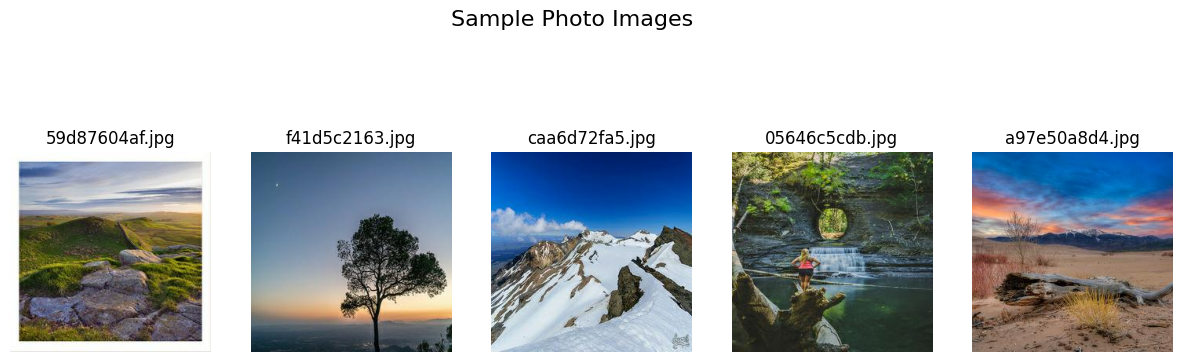

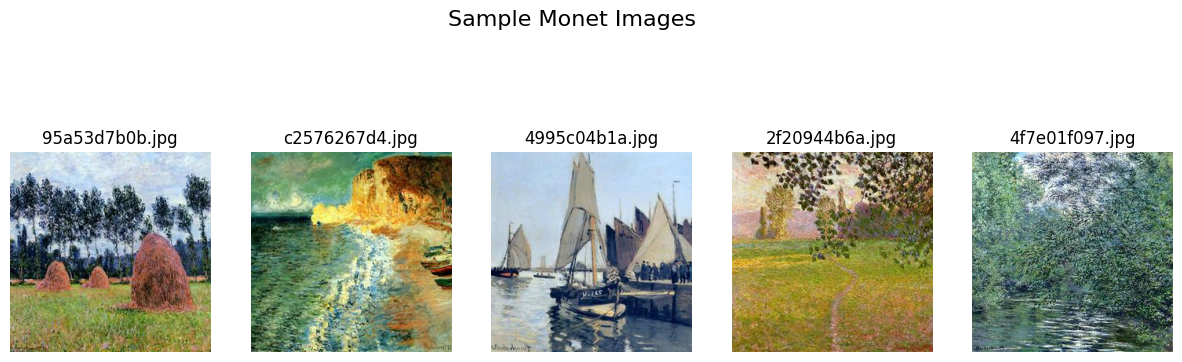

In [3]:
num_samples = 5

plt.figure(figsize=(15, 5))
for i, (filename, img) in enumerate(random.sample(list(photo_images.items()), num_samples)):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(filename)
    plt.axis('off')
plt.suptitle("Sample Photo Images", fontsize=16)
plt.show()

plt.figure(figsize=(15, 5))
for i, (filename, img) in enumerate(random.sample(list(monet_images.items()), num_samples)):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(filename)
    plt.axis('off')
plt.suptitle("Sample Monet Images", fontsize=16)
plt.show()

- The real photo images appear to be ordinary photographs, similar to what we typically see in daily life.
- Although it is not feasible to check all images due to their large number, most of them seem to feature natural landscapes.
- There are relatively few images primarily depicting people or artificial objects.
- Similarly, the Monet paintings also mainly illustrate natural scenery.
- While not extremely abstract, the Monet paintings clearly differ from the photos in terms of color tones and overall artistic style.
- These differences between the two categories are obvious to the human eye.


In [4]:
def transform_image_data(image_dict):
  if not image_dict:
    return None

  image_list = list(image_dict.values())
  image_shape = image_list[0].shape
  num_images = len(image_list)

  if not all(img.shape == image_shape for img in image_list):
      print("Error: Images have inconsistent shapes.")
      return None

  image_array = np.zeros((num_images, *image_shape), dtype=image_list[0].dtype)
  for i, img in enumerate(image_list):
      image_array[i] = img

  return image_array

photo_array = transform_image_data(photo_images)
monet_array = transform_image_data(monet_images)

print(f"Photo array shape: {photo_array.shape}")
print(f"Monet array shape: {monet_array.shape}")

Photo array shape: (7038, 256, 256, 3)
Monet array shape: (300, 256, 256, 3)


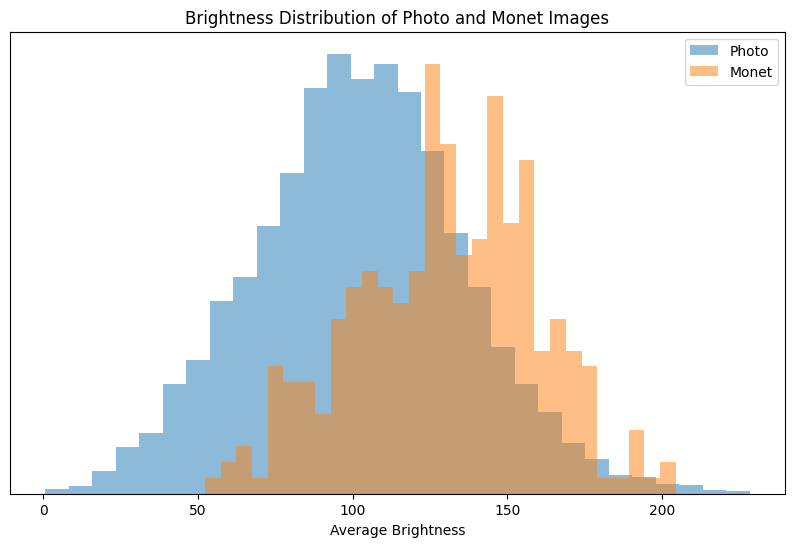

In [5]:
def compute_brightness(image_array):
    weights = np.array([0.299, 0.587, 0.114])
    if image_array.shape[-1] != 3:
        raise ValueError("Expected 3 channels (RGB).")
    brightness = np.tensordot(image_array, weights, axes=([-1], [0]))
    return brightness.mean(axis=(1, 2))

photo_brightness = compute_brightness(photo_array)
monet_brightness = compute_brightness(monet_array)

plt.figure(figsize=(10, 6))
plt.hist(photo_brightness, bins=30, alpha=0.5, label='Photo', weights=np.ones(len(photo_brightness)) *100/ len(photo_brightness))
plt.hist(monet_brightness, bins=30, alpha=0.5, label='Monet', weights=np.ones(len(monet_brightness)) *100/ len(monet_brightness))
plt.xlabel('Average Brightness')
plt.ylabel('Percentage of Images')
plt.gca().get_yaxis().set_visible(False)
plt.title('Brightness Distribution of Photo and Monet Images')
plt.legend(loc='upper right')
plt.show()


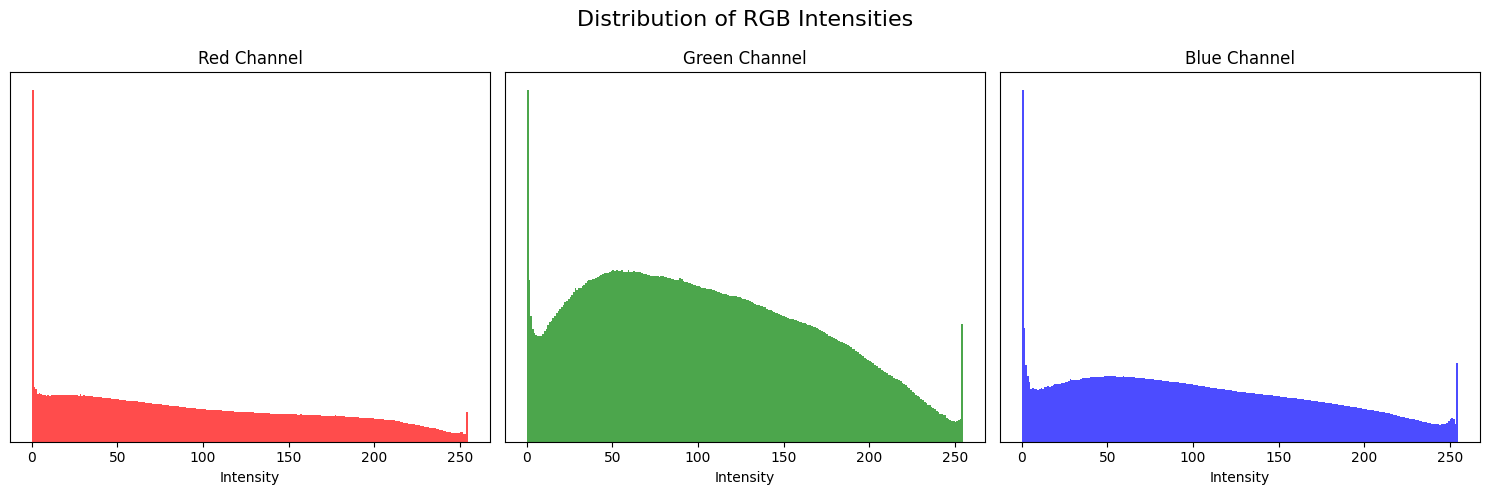

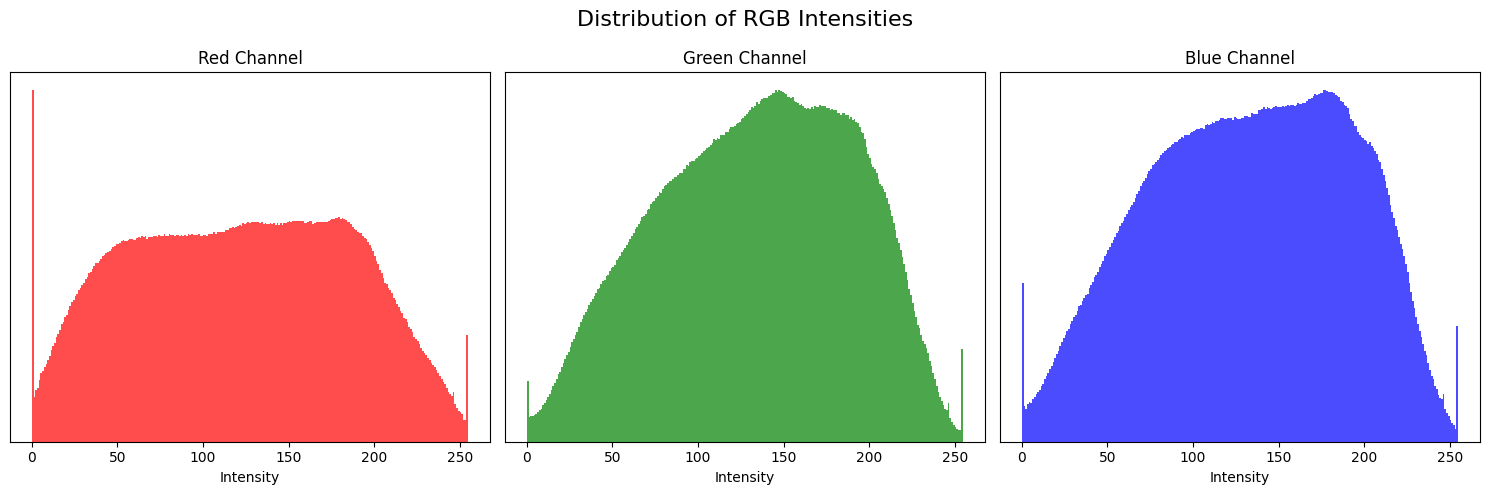

In [6]:
def plot_rgb_distribution(image_array):
    r_channel = image_array[..., 0].flatten()
    g_channel = image_array[..., 1].flatten()
    b_channel = image_array[..., 2].flatten()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].hist(r_channel, bins=255, color='red', alpha=0.7, weights=np.ones(len(r_channel)) * 100 / len(r_channel))
    axes[0].set_title('Red Channel')
    axes[0].set_xlabel('Intensity')
    axes[0].set_ylabel('Percentage of Pixels')
    axes[0].get_yaxis().set_visible(False)

    axes[1].hist(g_channel, bins=255, color='green', alpha=0.7, weights=np.ones(len(g_channel)) * 100 / len(g_channel))
    axes[1].set_title('Green Channel')
    axes[1].set_xlabel('Intensity')
    axes[1].set_ylabel('Percentage of Pixels')
    axes[1].get_yaxis().set_visible(False)

    axes[2].hist(b_channel, bins=255, color='blue', alpha=0.7, weights=np.ones(len(b_channel)) * 100 / len(b_channel))
    axes[2].set_title('Blue Channel')
    axes[2].set_xlabel('Intensity')
    axes[2].set_ylabel('Percentage of Pixels')
    axes[2].get_yaxis().set_visible(False)

    plt.suptitle('Distribution of RGB Intensities', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_rgb_distribution(photo_array)
plot_rgb_distribution(monet_array)


### Observation
- Monet's images tend to exhibit higher brightness levels.  
- In particular, they appear to contain fewer dark (black) regions.
- However, there is still considerable overlap in the distributions between the two domains.

# Follows on the next notebook (CSCA5642_Week5_Training.ipynb)

### Disclosure
AI-assisted code completion was used in non-essential parts of the notebook.